# PopStar Quick Start: Making A Cluster

This is a quick start guide to making a synthetic cluster using the PopStar package. The cluster is constructed using a user-specified isochrone and initial mass function (IMF). Detailed documentation with all the available options to the user at each step is provided in [XXX].

Before starting this tutorial, it is assumed that PopStar has been installed and the user's python path has been altered to include the PopStar top-level directory

In [1]:
# Import necessary packages. 
from popstar import synthetic, evolution, atmospheres, reddening, ifmr
from popstar.imf import imf, multiplicity
import numpy as np
import pylab as py
import pdb
import matplotlib.pyplot as plt

/Users/mwhosek/anaconda3/envs/astroconda/lib/python3.5/site-packages/pysynphot/locations.py:329: UserWarning: Extinction files not found in /Users/mwhosek/models/models_2019_06/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


#### Step 1: Make a PopStar isochrone object

The cluster is made from a theoretical isochrone at a given age, extinction, and distance from Earth. These parameters MUST be specified by the user. Other inputs (e.g. stellar evolution/atmosphere models, extinction law, and photometric filters used) are optional keywords. See documentation for all keywords and their default values.

Here, we create a 5 Myr cluster isochrone at an extinction of 0.8 mags and distance of 4000 pc from Earth.

In [2]:
# Define isochrone parameters
logAge = np.log10(5*10**6.) # Age in log(years)
AKs = 0.8 # extinction in mags
dist = 4000 # distance in parsec
metallicity = 0 # Metallicity in [M/H]

# Define evolution/atmosphere models and extinction law
evo_model = evolution.MergedBaraffePisaEkstromParsec() 
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()

# Also specify filters for synthetic photometry (optional). Here we use 
# the HST WFC3-IR F127M, F139M, and F153M filters
filt_list = ['wfc3,ir,f127m', 'wfc3,ir,f139m', 'wfc3,ir,f153m']

# Make Isochrone object. Note that is calculation will take a few minutes, unless the 
# isochrone has been generated previously.
my_iso = synthetic.IsochronePhot(logAge, AKs, dist, metallicity=0,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list)

Changing to logg=4.0 for T= 32651 logg=3.99
Changing to logg=4.0 for T= 32840 logg=3.98
Changing to logg=4.0 for T= 33037 logg=3.97
Changing to logg=4.0 for T= 33144 logg=3.96
Changing to logg=4.0 for T= 33205 logg=3.95
Changing to logg=4.0 for T= 33358 logg=3.94
Changing to logg=4.0 for T= 33504 logg=3.93
Changing to logg=4.0 for T= 33651 logg=3.91
Changing to logg=4.0 for T= 33713 logg=3.91
Changing to logg=4.0 for T= 33775 logg=3.90
Changing to logg=4.0 for T= 33892 logg=3.89
Changing to logg=4.0 for T= 34002 logg=3.87
Changing to logg=4.0 for T= 34111 logg=3.86
Changing to logg=4.0 for T= 34182 logg=3.85
Changing to logg=4.0 for T= 34222 logg=3.85
Changing to logg=4.0 for T= 34332 logg=3.83
Changing to logg=4.0 for T= 34443 logg=3.82
Changing to logg=4.0 for T= 34546 logg=3.81
Changing to logg=4.0 for T= 34658 logg=3.80
Changing to logg=4.0 for T= 34674 logg=3.80
Changing to logg=4.0 for T= 34746 logg=3.79
Changing to logg=4.0 for T= 34842 logg=3.78
Changing to logg=4.0 for T= 3493

Changing to logg=5.0 for T= 33504 logg=5.13
Changing to logg=5.0 for T= 33466 logg=5.08
Changing to logg=5.0 for T= 33504 logg=5.08
Changing to logg=5.0 for T= 33558 logg=5.07
Changing to logg=5.0 for T= 33605 logg=5.08
Changing to logg=5.0 for T= 33651 logg=5.08
Changing to logg=5.0 for T= 33674 logg=5.07
Changing to logg=5.0 for T= 32870 logg=5.05
Changing to logg=5.0 for T= 30054 logg=5.01
Changing to logg=5.0 for T= 29819 logg=5.01
Changing to logg=5.0 for T= 35785 logg=5.39
Changing to logg=5.0 for T= 39683 logg=5.62
Changing to logg=5.0 for T= 39701 logg=5.62
Changing to logg=5.0 for T= 39655 logg=5.63
Changing to logg=5.0 for T= 39518 logg=5.63
Changing to logg=5.0 for T= 39373 logg=5.63
Changing to logg=5.0 for T= 39518 logg=5.65
Changing to logg=5.0 for T= 40031 logg=5.69
Changing to logg=5.0 for T= 40096 logg=5.70
Changing to logg=5.0 for T= 40495 logg=5.74
Changing to logg=5.0 for T= 41381 logg=5.82
Changing to logg=5.0 for T= 41976 logg=5.87
Changing to logg=5.0 for T= 4219

Changing temp from 57570 to 50000
Changing to logg=5.0 for T= 50000 logg=6.11
Changing temp from 57703 to 50000
Changing to logg=5.0 for T= 50000 logg=6.11
Changing temp from 57850 to 50000
Changing to logg=5.0 for T= 50000 logg=6.12
Changing temp from 57983 to 50000
Changing to logg=5.0 for T= 50000 logg=6.12
Changing temp from 58117 to 50000
Changing to logg=5.0 for T= 50000 logg=6.12
Changing temp from 58251 to 50000
Changing to logg=5.0 for T= 50000 logg=6.13
Changing temp from 58398 to 50000
Changing to logg=5.0 for T= 50000 logg=6.13
Changing temp from 58546 to 50000
Changing to logg=5.0 for T= 50000 logg=6.13
Changing temp from 58695 to 50000
Changing to logg=5.0 for T= 50000 logg=6.13
Changing temp from 58844 to 50000
Changing to logg=5.0 for T= 50000 logg=6.14
Changing temp from 58993 to 50000
Changing to logg=5.0 for T= 50000 logg=6.14
Changing temp from 59143 to 50000
Changing to logg=5.0 for T= 50000 logg=6.14
Changing temp from 59293 to 50000
Changing to logg=5.0 for T= 50

Once calculated, the isochrone will be written as a fits file to a location set by the "iso_dir" keyword (not shown here; default location is current working directory). In the future, the IsochronePhot function will read this file directly rather than recalculating the isochrone again. 

The file name will be the following: "iso_logAge_AKs_distance.fits, using the specified values

In [3]:
# The individual points in the isochrone can be accessed using the points subfunction 
# on the isochrone object. This produces an astropy table that contains the 
# list of stellar masses in the isochrone and their associated properties
print(my_iso.points)

          L                   Teff        ...    m_hst_f153m    
          W                    K          ...                   
---------------------- ------------------ ... ------------------
 6.591312905046435e+24  2928.195035574271 ... 21.454393405994317
  7.13135291244921e+24 2943.7437337117412 ... 21.366522688728868
 7.761969450327467e+24 2958.6936525140045 ... 21.272755867654716
 8.296060854703104e+24  2975.089258880875 ... 21.199052286364093
 8.830228238420424e+24  2992.264636608189 ... 21.130349503148018
 8.860779496066351e+24  3009.539168873201 ...   21.1268524903858
 8.889389363240369e+24  3026.913428101305 ...  21.12475106804226
1.1365065135674554e+25  3065.490679425787 ...   20.8616374881783
1.3837955482036446e+25  3103.844819159537 ...  20.65220438788622
 1.631443091163686e+25  3142.678829879227 ...     20.46963686363
                   ...                ... ...                ...
2.0430167585847428e+32  61503.52393069763 ... 11.147069143378806
2.0524468954776198e+32  6

In [9]:
# The isochrone table has meta keywords describing its properties
print(my_iso.points.meta)

OrderedDict([('REDLAW', 'H18b'), ('ATMFUNC', 'get_merged_atmosphere'), ('EVOMODEL', 'MergedBaraffePisaEkstromParsec'), ('LOGAGE', 6.698970004336019), ('AKS', 0.8), ('DISTANCE', 4000), ('METAL_IN', 0), ('METAL_ACT', 0.0), ('WAVEMIN', 5000), ('WAVEMAX', 52000)])


In [10]:
print('The columns in the isochrone table are: {0}'.format(my_iso.points.keys()))

The columns in the isochrone table are: ['L', 'Teff', 'R', 'mass', 'logg', 'isWR', 'mass_current', 'phase', 'm_hst_f127m', 'm_hst_f139m', 'm_hst_f153m']


In [11]:
# Identify a 1 M_sun star, print F127M, F139M, and F153M mags
idx = np.where( abs(my_iso.points['mass'] - 1.0) == min(abs(my_iso.points['mass'] - 1.0)) )[0]
f127m = np.round(my_iso.points[idx[0]]['m_hst_f127m'], decimals=3)
f139m = np.round(my_iso.points[idx[0]]['m_hst_f139m'], decimals=3)
f153m = np.round(my_iso.points[idx[0]]['m_hst_f153m'], decimals=3)
print('1 M_sun: F127M = {0} mag, F139M = {1} mag, F153M = {2} mag'.format(f127m, f139m, f153m))

1 M_sun: F127M = 19.051 mag, F139M = 18.453 mag, F153M = 17.785 mag


In [12]:
# Make a color-magnitude diagram
py.figure(1, figsize=(10,10))
py.clf()
py.plot(my_iso.points['m_hst_f127m'] - my_iso.points['m_hst_f153m'], 
       my_iso.points['m_hst_f153m'], 'r-', label='_nolegend_')
py.plot(my_iso.points['m_hst_f127m'][idx] - my_iso.points['m_hst_f153m'][idx], 
       my_iso.points['m_hst_f153m'][idx], 'b*', ms=15, label='1 M_sun')
py.xlabel('F127M - F153M')
py.ylabel('F153M')
py.gca().invert_yaxis()
py.legend()

### Step 2: Make an Initial Mass Function

PopStar offers a range of initial mass functions (IMFs) a user can use from to make the cluster. In addition to the parameters defining the IMF, the user can pass in a PopStar multiplicity object, which defines the multiplicity properties of the population. The default multiplicity is None (e.g. all stars are single).

Here we define a Kroupa IMF using the Multiplicity properties defined in Lu+13. 

In [13]:
# Make multiplicity object
imf_multi = multiplicity.MultiplicityUnresolved()

# Make IMF object; we'll use a broken power law with the parameters from Kroupa+01
massLimits = np.array([0.08, 0.5, 1, 120]) # Define boundaries of each mass segement
powers = np.array([-1.3, -2.3, -2.3]) # Power law slope associated with each mass segment
my_imf = imf.IMF_broken_powerlaw(massLimits, powers, imf_multi)

## Note: there is a Kroupa_2001 IMF object in the popstar/imf.py that one could use
## to generate the Kroupa+01 IMF. However, the Kroupa_2001 IMF object contains masses
## down to 0.01 M_sun, which is beyond the lower limit of our isochrones. As a result,
## the synthetic photometry of these stars systems are non-sensical 
##
## If the user isn't interested in the photometry, then they could define the 
## IMF object as:
## my_imf = imf.Kroupa_2001(multiplicity=imf_multi)

### Step 3: Make the Cluster  
#### Option 1: No compact objects
To create the cluster, the user passes in an isochrone object, and imf object, and specifies the total cluster mass. Here we will make a 10^5 M_sun cluster using the isochrone and imf we have defined.

The individual star systems in the cluster and their properties are stored in an astropy table accessed by the star_systems subfunction on the cluster object. Note that the photometry of these star systems includes the contributions from all companions, which are generated probabilistically using the multiplicity defined in the IMF object.

In [14]:
# Define total cluster mass
mass = 10**5.

# Make cluster object
cluster = synthetic.ResolvedCluster(my_iso, my_imf, mass)

# Look at star systems table
print(cluster.star_systems)

Found 48 stars out of mass range
        mass        isMultiple ...    m_hst_f153m     N_companions
------------------- ---------- ... ------------------ ------------
 0.8844887838429392      False ... 17.966610416220476            0
0.14253453602368965      False ...  20.62906818953706            0
 0.1177584800943184      False ...  20.89112620451431            0
0.12656085009685444      False ...  20.79293452936151            0
 0.5395502142923635      False ... 18.687445358987418            0
0.15070436107753468      False ... 20.554490952852714            0
0.08587082435054391      False ... 21.187086675049155            0
 0.7439451034404229      False ... 18.217260251819006            0
0.08252349882165823      False ...  21.23555768754694            0
  0.586311821631537      False ... 18.568569196231124            0
                ...        ... ...                ...          ...
 0.7055412354775995      False ...  18.29442635215045            0
0.10113886206569232      Fals

In [15]:
print('The cluster table contains these columns: {0}'.format(cluster.star_systems.keys()))

The cluster table contains these columns: ['mass', 'isMultiple', 'systemMass', 'Teff', 'L', 'logg', 'isWR', 'mass_current', 'phase', 'm_hst_f127m', 'm_hst_f139m', 'm_hst_f153m', 'N_companions']


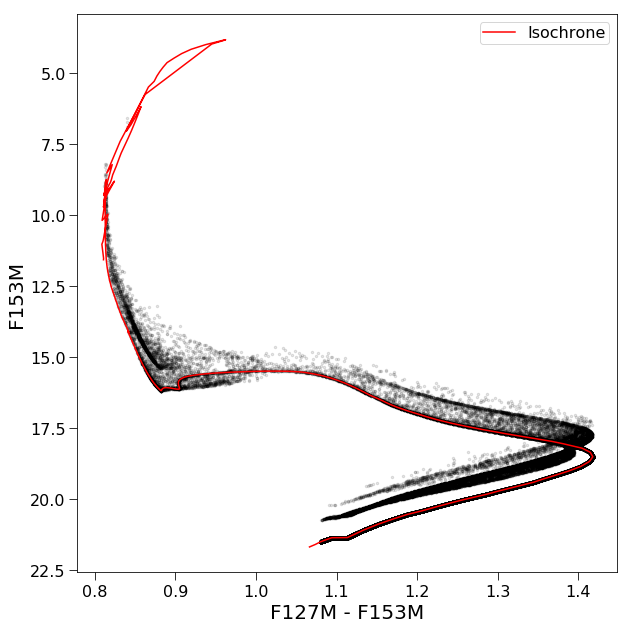

In [10]:
# Look at the cluster CMD, compared to input isochrone. Note the impact of
# multiple systems on the photometry
clust = cluster.star_systems
iso = my_iso.points

py.figure(2, figsize=(10,10))
py.clf()
py.plot(clust['m_hst_f127m'] - clust['m_hst_f153m'], clust['m_hst_f153m'],
       'k.', ms=5, alpha=0.1, label='__nolegend__')
py.plot(iso['m_hst_f127m'] - iso['m_hst_f153m'], iso['m_hst_f153m'],
       'r-', label='Isochrone')
py.xlabel('F127M - F153M')
py.ylabel('F153M')
py.gca().invert_yaxis()
py.legend()

#### Option 2: Compact objects (white dwarfs, neutron stars, and black holes)
This is quite similar to the above, but includes compact objects. The additional piece of information required is to choose an initial-final mass relation (IFMR.) Currently there's only one choice in PopStar, so that makes your decision easy...

The output is the same as if we were making a cluster without using an IFMR. However, you can tell that compact objects are made by looking at the 'phase' keyword. Black holes have 'phase' = 103, neutron stars have 'phase' = 102, and white dwarfs have 'phase' = 101. For these compact objects, the luminosity, temperature, and photometry will return values of 0, since we are assuming they are totally dark.

Here, we make 4 different clusters, each of mass $10^6 M_\odot$, by taking different combinations of age (either 100 Myr or 10 Gyr) and IMF (top-heavy or Kroupa). We then look at the different distributions of BH and WD masses. (Since NSs are all assigned a single mass in the IFMR, the mass distribution there is not very interesting. However, the relative number of NSs for each cluster will be different.)

In [16]:
# Create isochrone object  
filt_list = ['wfc3,ir,f153m'] # We won't be doing much with synthetic photometry here, so only 1 filter
my_ifmr = ifmr.IFMR()
my_iso_young = synthetic.IsochronePhot(8, 0, 10,
                                 evo_model = evolution.MISTv1(),
                                      filters=filt_list)

my_iso_old = synthetic.IsochronePhot(10, 0, 10,
                                 evo_model = evolution.MISTv1(),
                                    filters=filt_list)
# Create IMF object                                                                                                                                                        
massLimits = np.array([0.1, 0.5, 120])
powers_kroupa = np.array([-1.3, -2.3])
powers_theavy = np.array([-1.3, -1.3]) # top heavy
trunc_kroupa = imf.IMF_broken_powerlaw(massLimits, powers_kroupa)
trunc_theavy = imf.IMF_broken_powerlaw(massLimits, powers_theavy)

# Make cluster                                                                                                                                                             
cluster_mass = 10**6
cluster_young_theavy = synthetic.ResolvedCluster(my_iso_young, trunc_theavy, cluster_mass, ifmr=my_ifmr)
cluster_old_theavy = synthetic.ResolvedCluster(my_iso_old, trunc_theavy, cluster_mass, ifmr=my_ifmr)
cluster_young_kroupa = synthetic.ResolvedCluster(my_iso_young, trunc_kroupa, cluster_mass, ifmr=my_ifmr)
cluster_old_kroupa = synthetic.ResolvedCluster(my_iso_old, trunc_kroupa, cluster_mass, ifmr=my_ifmr)

# Get the outputs
young_theavy = cluster_young_theavy.star_systems
old_theavy = cluster_old_theavy.star_systems
young_kroupa = cluster_young_kroupa.star_systems
old_kroupa = cluster_old_kroupa.star_systems

Changing to logg=2.5 for T=  3793 logg=0.74
Changing to logg=2.5 for T=  3780 logg=0.72
Changing to logg=2.5 for T=  3767 logg=0.70
Changing to logg=2.5 for T=  3754 logg=0.68
Changing to logg=2.5 for T=  3741 logg=0.66
Changing to logg=2.5 for T=  3728 logg=0.64
Changing to logg=2.5 for T=  3716 logg=0.62
Changing to logg=2.5 for T=  3704 logg=0.60
Changing to logg=2.5 for T=  3691 logg=0.58
Changing to logg=2.5 for T=  3679 logg=0.56
Changing to logg=2.5 for T=  3666 logg=0.54
Changing to logg=2.5 for T=  3654 logg=0.52
Changing to logg=2.5 for T=  3642 logg=0.50
Changing to logg=2.5 for T=  3630 logg=0.48
Changing to logg=2.5 for T=  3618 logg=0.46
Changing to logg=2.5 for T=  3606 logg=0.44
Changing to logg=2.5 for T=  3594 logg=0.42
Changing to logg=2.5 for T=  3582 logg=0.40
Changing to logg=2.5 for T=  3571 logg=0.39
Changing to logg=2.5 for T=  3559 logg=0.37
Changing to logg=2.5 for T=  3548 logg=0.35
Changing to logg=2.5 for T=  3536 logg=0.33
Changing to logg=2.5 for T=  352

M =   1.612 Msun  T =  7715 K  m_nirc2_Kp = 2.10
M =   4.773 Msun  T = 13582 K  m_nirc2_Kp = -1.27
M =   5.013 Msun  T = 10084 K  m_nirc2_Kp = -2.77
M =   5.020 Msun  T =  4310 K  m_nirc2_Kp = -5.19
M =   5.271 Msun  T =  4854 K  m_nirc2_Kp = -5.37
M =   5.321 Msun  T =  3454 K  m_nirc2_Kp = -8.32
M =   5.324 Msun  T = 26655 K  m_nirc2_Kp = -3.09
M =   5.324 Msun  T = 192342 K  m_nirc2_Kp = 3.29
Starting filter: ubv,V   Elapsed time: 217.48 seconds
Starting synthetic photometry
M =   0.112 Msun  T =  3010 K  m_ubv_V = 14.38
M =   1.612 Msun  T =  7715 K  m_ubv_V = 2.68
M =   4.773 Msun  T = 13582 K  m_ubv_V = -1.53
M =   5.013 Msun  T = 10084 K  m_ubv_V = -2.77
M =   5.020 Msun  T =  4310 K  m_ubv_V = -2.16
M =   5.271 Msun  T =  4854 K  m_ubv_V = -3.02
M =   5.321 Msun  T =  3454 K  m_ubv_V = -2.94
M =   5.324 Msun  T = 26655 K  m_ubv_V = -3.68
M =   5.324 Msun  T = 192342 K  m_ubv_V = 2.32
Starting filter: wfc3,ir,f153m   Elapsed time: 235.61 seconds
Starting synthetic photometry
M =

Changing to logg=5.0 for T=  2942 logg=5.21
Changing to logg=5.0 for T=  2927 logg=5.22
Changing to logg=5.0 for T=  2948 logg=5.21
Changing to logg=5.0 for T=  2963 logg=5.20
Changing to logg=5.0 for T=  2990 logg=5.19
Changing to logg=5.0 for T=  3020 logg=5.17
Changing to logg=5.0 for T=  3051 logg=5.16
Changing to logg=5.0 for T=  3084 logg=5.14
Changing to logg=5.0 for T=  3117 logg=5.12
Changing to logg=5.0 for T=  3146 logg=5.10
Changing to logg=5.0 for T=  3172 logg=5.08
Changing to logg=5.0 for T=  3196 logg=5.07
Changing to logg=2.5 for T=  3799 logg=1.23
Changing to logg=2.5 for T=  3781 logg=1.20
Changing to logg=2.5 for T=  3764 logg=1.17
Changing to logg=2.5 for T=  3746 logg=1.14
Changing to logg=2.5 for T=  3728 logg=1.11
Changing to logg=2.5 for T=  3710 logg=1.08
Changing to logg=2.5 for T=  3692 logg=1.04
Changing to logg=2.5 for T=  3674 logg=1.01
Changing to logg=2.5 for T=  3657 logg=0.98
Changing to logg=2.5 for T=  3638 logg=0.95
Changing to logg=2.5 for T=  362

Changing to logg=2.5 for T=  3194 logg=0.12
Changing to logg=2.5 for T=  3207 logg=0.14
Changing to logg=2.5 for T=  3221 logg=0.16
Changing to logg=2.5 for T=  3234 logg=0.19
Changing to logg=2.5 for T=  3248 logg=0.21
Changing to logg=2.5 for T=  3261 logg=0.23
Changing to logg=2.5 for T=  3275 logg=0.25
Changing to logg=2.5 for T=  3288 logg=0.28
Changing to logg=2.5 for T=  3301 logg=0.30
Changing to logg=2.5 for T=  3313 logg=0.32
Changing to logg=2.5 for T=  3325 logg=0.34
Changing to logg=2.5 for T=  3337 logg=0.36
Changing to logg=2.5 for T=  3339 logg=0.36
Changing to logg=2.5 for T=  3330 logg=0.34
Changing to logg=2.5 for T=  3321 logg=0.33
Changing to logg=2.5 for T=  3312 logg=0.31
Changing to logg=2.5 for T=  3302 logg=0.30
Changing to logg=2.5 for T=  3293 logg=0.28
Changing to logg=2.5 for T=  3284 logg=0.27
Changing to logg=2.5 for T=  3274 logg=0.25
Changing to logg=2.5 for T=  3265 logg=0.23
Changing to logg=2.5 for T=  3256 logg=0.22
Changing to logg=2.5 for T=  324

M =   1.029 Msun  T =  4478 K  m_hst_f160w = -1.70
M =   1.032 Msun  T =  4241 K  m_hst_f160w = -2.55
M =   1.033 Msun  T =  3344 K  m_hst_f160w = -5.51
M =   1.033 Msun  T =  3288 K  m_hst_f160w = -5.63
M =   1.033 Msun  T =  3195 K  m_hst_f160w = -5.79
M =   1.033 Msun  T = 10790 K  m_hst_f160w = -3.77
M =   1.033 Msun  T = 61970 K  m_hst_f160w = 1.61
M =   1.033 Msun  T = 83275 K  m_hst_f160w = 7.40
Starting filter: ubv,U   Elapsed time: 52.51 seconds
Starting synthetic photometry
M =   0.109 Msun  T =  2942 K  m_ubv_U = 22.27
M =   0.826 Msun  T =  5218 K  m_ubv_U = 14.30
M =   1.025 Msun  T =  4564 K  m_ubv_U = 10.19
M =   1.029 Msun  T =  4478 K  m_ubv_U = 9.12
M =   1.032 Msun  T =  4241 K  m_ubv_U = 8.47
M =   1.033 Msun  T =  3344 K  m_ubv_U = 7.05
M =   1.033 Msun  T =  3288 K  m_ubv_U = 7.06
M =   1.033 Msun  T =  3195 K  m_ubv_U = 7.17
M =   1.033 Msun  T = 10790 K  m_ubv_U = 5.44
M =   1.033 Msun  T = 61970 K  m_ubv_U = 10.25
M =   1.033 Msun  T = 83275 K  m_ubv_U = 16.02


In [17]:
young_theavy_bh_idx = np.where(young_theavy['phase'] == 103)[0]
old_theavy_bh_idx = np.where(old_theavy['phase'] == 103)[0]
young_kroupa_bh_idx = np.where(young_kroupa['phase'] == 103)[0]
old_kroupa_bh_idx = np.where(old_kroupa['phase'] == 103)[0]

bh_bins = np.linspace(5, 16, 16)
wd_bins = np.linspace(0.4, 1.4, 16)

plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.hist(young_theavy[young_theavy_bh_idx]['mass_current'], histtype = 'step',
        bins = bh_bins, label = '100 Myr, TH IMF', color = 'red', linestyle = ':', lw = 2)
plt.hist(old_theavy[old_theavy_bh_idx]['mass_current'], histtype = 'step',
        bins = bh_bins, label = '10 Gyr, TH IMF', color = 'gray', linestyle = ':', lw = 2)
plt.hist(young_kroupa[young_kroupa_bh_idx]['mass_current'], histtype = 'step',
        bins = bh_bins, label = '100 Myr, Kr IMF', color = 'red', lw = 2)
plt.hist(old_kroupa[old_kroupa_bh_idx]['mass_current'], histtype = 'step',
        bins = bh_bins, label = '10 Gyr, Kr IMF', color = 'gray', lw = 2)
plt.title('BH Mass Function')
plt.xlabel('Mass ($M_\odot$)')
plt.ylabel('Number')
plt.legend()

young_theavy_wd_idx = np.where(young_theavy['phase'] == 101)[0]
old_theavy_wd_idx = np.where(old_theavy['phase'] == 101)[0]
young_kroupa_wd_idx = np.where(young_kroupa['phase'] == 101)[0]
old_kroupa_wd_idx = np.where(old_kroupa['phase'] == 101)[0]

plt.subplot(1, 2, 2)
plt.hist(young_theavy[young_theavy_wd_idx]['mass_current'], histtype = 'step',
        bins = wd_bins, label = '100 Myr, TH IMF', color = 'red', linestyle = ':', lw = 2)
plt.hist(old_theavy[old_theavy_wd_idx]['mass_current'], histtype = 'step',
        bins = wd_bins, label = '10 Gyr, TH IMF', color = 'gray', linestyle = ':', lw = 2)
plt.hist(young_kroupa[young_kroupa_wd_idx]['mass_current'], histtype = 'step',
        bins = wd_bins, label = '100 Myr, Kr IMF', color = 'red', lw = 2)
plt.hist(old_kroupa[old_kroupa_wd_idx]['mass_current'], histtype = 'step',
        bins = wd_bins, label = '10 Gyr, Kr IMF', color = 'gray', lw = 2)
plt.yscale('log')
plt.title('WD Mass Function')
plt.xlabel('Mass ($M_\odot$)')
plt.legend()

Plotted above are the distributions of BH and WD masses for clusters of different ages (100 Myr or 10 Gyr), with either a top-heavy or Kroupa IMF. For BHs, since those are formed relatively early on, the age of the cluster does not significantly change the mass distribution as most BHs have already formed by 100 Myr. However, the top heavy IMF allows the creation of many more massive compact objects. For WDs, both the age and IMF make significant differences in the distribution (note y-axis is logscaled).

### I am not so sure about the stuff below... leaving, but it's "in progress" for now.

In [14]:
# Plot "HR" diagram
# Not sure what is up with that point in the right corner...
# THIS PLOT NEEDS UNITSSSS
# wd_idx = np.where(output['phase'] == 6)[0]
# lum = output['L'][wd_idx]
# temp = output['Teff'][wd_idx]
# py.plot(temp, lum, '.')
# py.gca().invert_xaxis()
# py.xscale('log')
# py.yscale('log')
# py.show()

In [15]:
# The MIST (luminous) WDs
# wd_idx = np.where((output['phase'] == 6) & (output['logg'] > 1))[0]
# mass = output['mass'][wd_idx]
# radius = np.sqrt(output['mass'][wd_idx] / output['logg'][wd_idx])
# py.plot(mass, output['logg'][wd_idx], '.')
#py.plot(mass, radius, '.')
# py.xscale('log')
# py.yscale('log')
 #py.show()